# Previsão de Qualidade do Ar

## Proposta

O objetivo é prever a qualidade do ar em algumas cidades turísticas do Chile com base nas condições climáticas. O fator escolhido para definir a qualidade do ar é o PM 2.5, que são materiais particulados leves o suficiennte para ficar suspensos no ar. Esse foi o fator escolhido por conta da sua influência na saúde humana, tanto em casos de exposição de curto quanto de longo prazo.

Para o bter os dados históricos de qualidade do ar, foi utilizada uma API da OpenAQ, que possui informações referentes a qualidade do a rcontidas em diversos sensores ao redor do mundo. Os dados climáticos foram obtidos da API Weather, trazendo os dados de um ano de diferentes informações climáticas sobre cidades específicas.

As features da tabela de medidas históricas do clima:
- **ds_city - Cidade**: cidade de origem das medidas
- **dt_date - Data**: data da medição
- **qt_avg_humidity - Umidade Média**: umidade média do dia
- **qt_avg_temp_c - Temperatura Média (°C)**: temperatura média do dia em °C
- **qt_avg_vis_km - Visibilidade Média (km)**: visibilidade média em km
- **qt_max_wind_kph - Velocidade Máxima do Vento (km/h)**: velocidade máxima do vento do dia em km/h
- **qt_total_precip_mm - Precipitação total (mm)**: precipitação total do dia em mm
- **qt_pressure_mb - Pressão Média (mb)**: pressão média do dia em mb

As features da tabela de medidas históricas de qualidade do ar são:
- **ds_city - Cidade**: cidade de origem das medidas
- **dt_date_from - Data de Início**: data e hora de início da medida
- **dt_date_to - Data de Término**: data e hora do final da medida
- **qt_pm25 - PM 2.5**:  material particulado de 2.5 mícrons ou menor

---
## Preparação dos Dados e Análise Exploratória

In [52]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import date, timedelta

In [53]:
# Configurar a conexão ao PostgreSQL
USER = "postgres"
PASSWORD = "password"
HOST = "localhost"  # Exemplo: "localhost" ou IP do servidor
PORT = "5432"  # Porta padrão do PostgreSQL
DB_NAME = "db_measurements"

# Criar a string de conexão
conn_str = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"

# Criar a engine de conexão
engine = create_engine(conn_str)

# Testar a conexão e carregar dados em um DataFrame
query = "SELECT * FROM tbl_weather_history"
df_weather_history = pd.read_sql(query, engine)

# Testar a conexão e carregar dados em um DataFrame
query = "SELECT * FROM tbl_measurements"
df_measurements = pd.read_sql(query, engine)

# Exibir as primeiras linhas
print(df_weather_history.head())

   id       ds_city     dt_date  qt_avg_humidity  qt_avg_temp_c  \
0   1  Puerto Montt  2024-03-28             76.0           14.4   
1   2  Puerto Montt  2024-03-29             78.0           12.5   
2   3  Puerto Montt  2024-03-30             75.0           10.1   
3   4  Puerto Montt  2024-03-31             73.0            9.2   
4   5  Puerto Montt  2024-04-01             72.0            9.1   

   qt_avg_vis_km  qt_max_wind_kph  qt_total_precip_mm  qt_pressure_mb  
0           10.0              7.6                 2.0         1018.75  
1            8.7             15.8                 3.2         1020.08  
2            8.7             11.5                 1.5         1024.50  
3           10.0             13.3                 0.0         1023.04  
4           10.0              8.3                 0.0         1019.50  


In [54]:
# estatisticas das features de histórico
df_measurements.head()

,id,id_sensor,ds_city,dt_date_from,dt_date_to,qt_pm25
0,1,491,Puerto Montt,2024-03-26 03:00:00,2024-03-27 03:00:00,14.0
1,2,491,Puerto Montt,2024-03-27 03:00:00,2024-03-28 03:00:00,14.2
2,3,491,Puerto Montt,2024-03-28 03:00:00,2024-03-29 03:00:00,30.4
3,4,491,Puerto Montt,2024-03-29 03:00:00,2024-03-30 03:00:00,18.1
4,5,491,Puerto Montt,2024-03-30 03:00:00,2024-03-31 03:00:00,24.1


In [55]:
df_weather_history['dt_date'] = df_weather_history['dt_date'].apply(lambda x: x.isoformat() if pd.notnull(x) else None)
df_weather_history.head()

,id,ds_city,dt_date,qt_avg_humidity,qt_avg_temp_c,qt_avg_vis_km,qt_max_wind_kph,qt_total_precip_mm,qt_pressure_mb
0,1,Puerto Montt,2024-03-28,76.0,14.4,10.0,7.6,2.0,1018.75
1,2,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.2,1020.08
2,3,Puerto Montt,2024-03-30,75.0,10.1,8.7,11.5,1.5,1024.50
3,4,Puerto Montt,2024-03-31,73.0,9.2,10.0,13.3,0.0,1023.04
4,5,Puerto Montt,2024-04-01,72.0,9.1,10.0,8.3,0.0,1019.50


In [56]:
df_measurements['dt_date'] = df_measurements['dt_date_from'].apply(lambda x: x.date().isoformat() if pd.notnull(x) else None)
df_measurements.head()

,id,id_sensor,ds_city,dt_date_from,dt_date_to,qt_pm25,dt_date
0,1,491,Puerto Montt,2024-03-26 03:00:00,2024-03-27 03:00:00,14.0,2024-03-26
1,2,491,Puerto Montt,2024-03-27 03:00:00,2024-03-28 03:00:00,14.2,2024-03-27
2,3,491,Puerto Montt,2024-03-28 03:00:00,2024-03-29 03:00:00,30.4,2024-03-28
3,4,491,Puerto Montt,2024-03-29 03:00:00,2024-03-30 03:00:00,18.1,2024-03-29
4,5,491,Puerto Montt,2024-03-30 03:00:00,2024-03-31 03:00:00,24.1,2024-03-30


In [57]:
# merge dos dois dataframes
df = pd.merge(df_weather_history, df_measurements, on=['ds_city', 'dt_date'], how='inner')
df.head()

,id_x,ds_city,dt_date,qt_avg_humidity,qt_avg_temp_c,qt_avg_vis_km,qt_max_wind_kph,qt_total_precip_mm,qt_pressure_mb,id_y,id_sensor,dt_date_from,dt_date_to,qt_pm25
0,1,Puerto Montt,2024-03-28,76.0,14.4,10.0,7.6,2.0,1018.75,3,491,2024-03-28 03:00:00,2024-03-29 03:00:00,30.4
1,1,Puerto Montt,2024-03-28,76.0,14.4,10.0,7.6,2.0,1018.75,363,21638,2024-03-28 03:00:00,2024-03-29 03:00:00,27.8
2,2,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.2,1020.08,4,491,2024-03-29 03:00:00,2024-03-30 03:00:00,18.1
3,2,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.2,1020.08,364,21638,2024-03-29 03:00:00,2024-03-30 03:00:00,17.8
4,3,Puerto Montt,2024-03-30,75.0,10.1,8.7,11.5,1.5,1024.50,5,491,2024-03-30 03:00:00,2024-03-31 03:00:00,24.1


In [58]:
# remocao de colunas
df.drop(columns=['id_x', 'id_y', 'id_sensor', 'dt_date_from', 'dt_date_to'], inplace=True)

In [59]:
# média da leitura dos sensores para cada cidade
df = df.groupby(['ds_city', 'dt_date']).mean().reset_index()
df.head()

,ds_city,dt_date,qt_avg_humidity,qt_avg_temp_c,qt_avg_vis_km,qt_max_wind_kph,qt_total_precip_mm,qt_pressure_mb,qt_pm25
0,Puerto Montt,2024-03-28,76.0,14.4,10.0,7.6,2.0,1018.75,29.10
1,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.2,1020.08,17.95
2,Puerto Montt,2024-03-30,75.0,10.1,8.7,11.5,1.5,1024.50,24.55
3,Puerto Montt,2024-03-31,73.0,9.2,10.0,13.3,0.0,1023.04,26.15
4,Puerto Montt,2024-04-01,72.0,9.1,10.0,8.3,0.0,1019.50,43.75


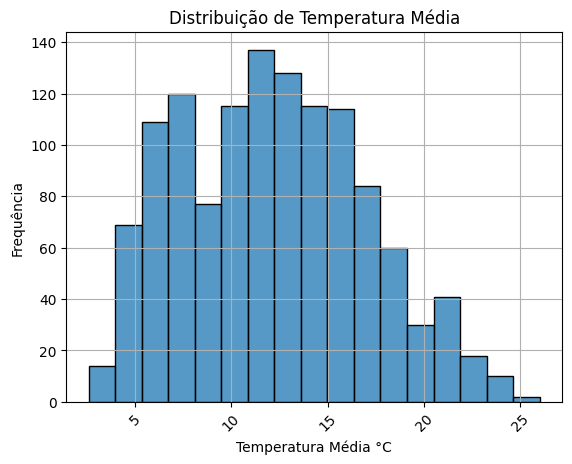

In [60]:
# distribuicao da temperatura média
sns.histplot(df['qt_avg_temp_c'])

# Configurar título e rótulos
plt.xlabel("Temperatura Média °C")
plt.ylabel("Frequência")
plt.title("Distribuição de Temperatura Média")
plt.xticks(rotation=45)  # Rotacionar datas para melhor visualização
plt.grid()

# Mostrar gráfico
plt.show()

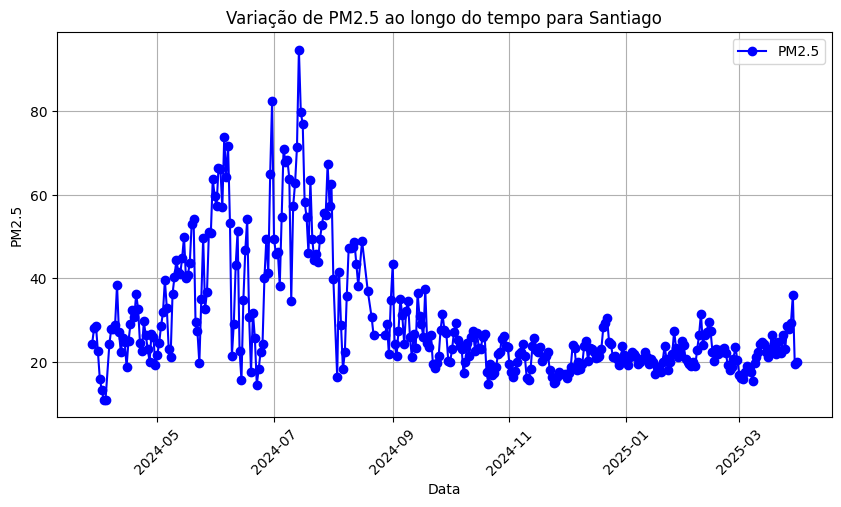

In [61]:
df["dt_date"] = pd.to_datetime(df["dt_date"])

df_pm25 = df.query('ds_city == "Santiago"')
# Criar o gráfico
plt.figure(figsize=(10,5))
plt.plot(df_pm25["dt_date"], df_pm25["qt_pm25"], marker="o", linestyle="-", color="b", label="PM2.5")

# Configurar título e rótulos
plt.xlabel("Data")
plt.ylabel("PM2.5")
plt.title("Variação de PM2.5 ao longo do tempo para Santiago")
plt.xticks(rotation=45)  # Rotacionar datas para melhor visualização
plt.legend()
plt.grid()

# Mostrar gráfico
plt.show()

---
## Pré Processamento

### Valores Duplicados

In [62]:
# verificação de existência de valores duplicados
print(df.duplicated().sum())

0


### Valores Faltantes

In [63]:
# verificação de valores faltantes
print(df.isnull().sum())

ds_city               0
dt_date               0
qt_avg_humidity       0
qt_avg_temp_c         0
qt_avg_vis_km         0
qt_max_wind_kph       0
qt_total_precip_mm    0
qt_pressure_mb        0
qt_pm25               0
dtype: int64


### Codificação de Variáveis Categóricas

In [64]:
from sklearn.preprocessing import OneHotEncoder

# Instanciando a classe do OneHotEncoder
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df[['ds_city']]).toarray()
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ds_city']))

# Concatenar os novos dados codificados ao dados
df = pd.concat([df, df_encoded], axis=1)
df.head()

,ds_city,dt_date,qt_avg_humidity,qt_avg_temp_c,qt_avg_vis_km,qt_max_wind_kph,qt_total_precip_mm,qt_pressure_mb,qt_pm25,ds_city_Puerto Montt,ds_city_Puerto Varas,ds_city_Santiago,ds_city_Valparaiso
0,Puerto Montt,2024-03-28,76.0,14.4,10.0,7.6,2.0,1018.75,29.10,1.0,0.0,0.0,0.0
1,Puerto Montt,2024-03-29,78.0,12.5,8.7,15.8,3.2,1020.08,17.95,1.0,0.0,0.0,0.0
2,Puerto Montt,2024-03-30,75.0,10.1,8.7,11.5,1.5,1024.50,24.55,1.0,0.0,0.0,0.0
3,Puerto Montt,2024-03-31,73.0,9.2,10.0,13.3,0.0,1023.04,26.15,1.0,0.0,0.0,0.0
4,Puerto Montt,2024-04-01,72.0,9.1,10.0,8.3,0.0,1019.50,43.75,1.0,0.0,0.0,0.0


### Feature Engineering

In [65]:
# Ordenar os dados por cidade e data
df = df.sort_values(['ds_city', 'dt_date'])

# Criar médias móveis para diferentes períodos
df['qt_pm25_ma3'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['qt_pm25_ma7'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['qt_pm25_ma14'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
df['qt_pm25_ema'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.ewm(span=7, adjust=False).mean())
df['qt_pm25_std7'] = df.groupby('ds_city')['qt_pm25'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df['qt_pm25_trend'] = df['qt_pm25_ma7'] - df['qt_pm25_ma3']

# Features de sazonalidade
df['dia_semana'] = pd.to_datetime(df['dt_date']).dt.dayofweek
df['mes_ano'] = pd.to_datetime(df['dt_date']).dt.month
df['estacao'] = pd.to_datetime(df['dt_date']).dt.month % 12 // 3 + 1

# Features de interação
df['temp_umidade'] = df['qt_avg_temp_c'] * df['qt_avg_humidity']
df['pressao_umidade'] = df['qt_pressure_mb'] * df['qt_avg_humidity']
df['vento_umidade'] = df['qt_max_wind_kph'] * df['qt_avg_humidity']

# Remover linhas com valores NaN
df = df.dropna()

---
## Divisão dos Dados em Treino e Teste

In [66]:
# Definir features para o modelo
features = [
    'qt_avg_humidity', 'qt_avg_temp_c', 'qt_avg_vis_km', 
    'qt_max_wind_kph', 'qt_total_precip_mm', 'qt_pressure_mb',
    'qt_pm25_ma3', 'qt_pm25_ma7', 'qt_pm25_ma14',
    'qt_pm25_ema', 'qt_pm25_std7', 'qt_pm25_trend',
    'dia_semana', 'mes_ano', 'estacao',
    'temp_umidade', 'pressao_umidade', 'vento_umidade'
] + [col for col in df.columns if col.startswith('ds_city_')]

# divisão dos dados
X = df[features]
y = df['qt_pm25']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Padronização

In [68]:
from sklearn.preprocessing import StandardScaler

# Inicializar o StandardScaler
scaler = StandardScaler()

# Ajustar o scaler apenas na base de treino
scaler.fit(X_train)

# Aplicar a transformação nas bases de treino e teste
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
## Definição de Métricas de Avaliação

In [69]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [70]:
# função para testar modelos de regressão e retornar valores das métricas
def reg_evaluation(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')
    return

---
## Treinamento dos Modelos

### Regressão Linear

In [71]:
from sklearn.linear_model import LinearRegression

# criando e treinando o modelo
reg_model = LinearRegression()
reg_evaluation(reg_model, X_train_scaled, y_train, X_test_scaled, y_test)

MSE: 84.02171060995516
RMSE: 9.166335724266004
MAPE: 0.166554979136639


### KNN Regressor

In [72]:
from sklearn.neighbors import KNeighborsRegressor

# criando e treinando o modelo
knn_reg_model = KNeighborsRegressor()
reg_evaluation(knn_reg_model, X_train_scaled, y_train, X_test_scaled, y_test)


MSE: 132.24388306451613
RMSE: 11.499734043207962
MAPE: 0.1872463754387595


### SVR

In [73]:
from sklearn.svm import SVR

# criando e treinando o modelo
svr_model = SVR()
reg_evaluation(svr_model, X_train_scaled, y_train, X_test_scaled, y_test)

MSE: 328.9881542593699
RMSE: 18.13803060586705
MAPE: 0.1666739667994405


### Árvore de Regressão

In [74]:
from sklearn.tree import DecisionTreeRegressor

# criando e treinando o modelo
tree_reg_model = DecisionTreeRegressor()
reg_evaluation(tree_reg_model, X_train_scaled, y_train, X_test_scaled, y_test)

MSE: 281.36351814516127
RMSE: 16.773893946998747
MAPE: 0.21872983084150915


### XGBoost

In [75]:
from xgboost import XGBRegressor

# criando e treinando o modelo
xgb_model = XGBRegressor()
reg_evaluation(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)

MSE: 158.71834609557487
RMSE: 12.59834695885039
MAPE: 0.1678728158393274


### Random Forest Regressor

In [76]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
reg_evaluation(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

MSE: 150.50138402318547
RMSE: 12.26790055482948
MAPE: 0.16785266154251288


---
## Otimização do Modelo

### Grid Search com Validação Cruzada

In [77]:
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definindo os parâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Criando o modelo
rf = RandomForestRegressor(random_state=42)

# Ajuste fino com validação cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinando o modelo com otimização
grid_search.fit(x_train, y_train)

# Exibindo os melhores parâmetros
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhores parâmetros encontrados:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [78]:
# Avaliando o desempenho no conjunto de teste
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# calculando as métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')

MSE: 139.72712599672366
RMSE: 11.82062291068976
MAPE: 0.1625113485091147


____

### Salva o modelo que será utilizado para a previsão.

In [79]:
import pickle

# salvar o modelo treinado
with open("best_rf_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!
